# FWI on field data (CGG Broadseis)

by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [31]:
import os
import sys
#api._cmd('conda activate torch2')
print(f'Python: {sys.prefix}')
import copy
import glob
import numpy as np
import importlib
import multiprocessing

import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize
import shared as sd
import loaders as ld
import vis
from IPython.display import clear_output
# append path with actual source files to sys.path
sys.path.append(os.path.abspath('../codes_server'))
from F_utils import *
from F_fwi import *
import pyapi_denise as api
api._cmd('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh')
api._cmd('source ~/.bashrc')
# create_sbatch_file_for_fwi_folder('./for_pasha/out_for_pasha/fwi_full_spectrum_vanilla')

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env
source /home/plotnips/Madagascar/share/madagascar/etc/env.sh
source ~/.bashrc


''

In [2]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [32]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [33]:
root_fwi = './out_for_pasha/'

# Init Denise API

In [34]:
denise_root = '../'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../bin/denise
Parse ../par/DENISE_marm_OBC.inp
Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./outputs/


## Work directory
Where to output everything

In [35]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/


# Get acquitision details

In [36]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

In [37]:
%run ./fwi_shared_check.ipynb

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
25.0
Assume even average spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
150.0
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [38]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))

Field data spacing between sources 149.75 m


In [39]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
    
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho

(152, 600)
./out_for_pasha/start/


Extend the model so it accommodates full streamer length for the last shot

In [40]:
vp = extend(model.vp, 0, 264 + 10 * 8)
vp_cgg_tomo=vp_cgg
vp_long = vp.copy()
vp_cgg_tomo_long = extend(vp_cgg_tomo, 0, 264 + 10 * 8)
print(vp_long.shape)

(152, 944)


## Acquisition design

In [41]:
# Wavelet scaler to match field and synthetic
wavefield_amp_ratio = 77.08343437940496

(152, 944)
(152, 844)
vp:	(152, 600), 1490.0000, 2969.2560 m/s

vs:	(152, 600), 0.0000, 1714.3007 m/s

rho:	(152, 600), 1000.0000, 2214.5349 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 14975.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


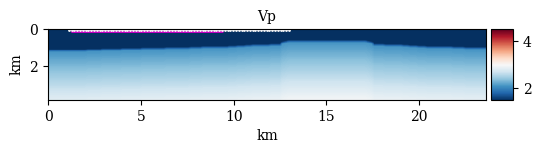

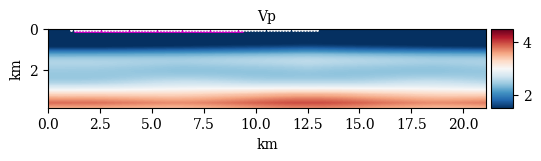

In [42]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wavefield_amp_ratio * wls[:, :limit_nt]

vis.plot_acquisition(vp, dx, src, rec, title='Vp',**{'vmax': 4.5, 'vmin': 1.5})
vis.plot_acquisition(vp_cgg_tomo_long, dx, src, rec, title='Vp',**{'vmax': 4.5, 'vmin': 1.5})
print(vp.shape)
print(vp_cgg_tomo_long.shape)
print(model)

In [43]:
wb_taper = np.where(vp_cgg_tomo_long < 1.01 * vp_cgg_tomo_long.min(), 1, 0)

Save /home/plotnips/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/vinit.png


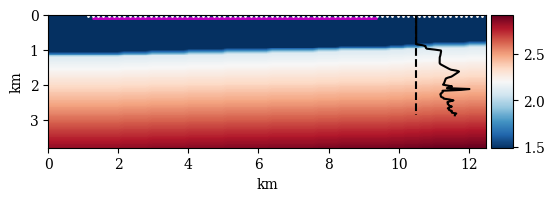

In [44]:
# log = model.vp[:, log_idx]
log = model.vp[-len(wlog):, log_idx]
# model_log = copy.deepcopy(model)

log_dict = {'data':wlog, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
vis.savefig('vinit.png')

In [45]:
print(wb_taper.shape)

(152, 844)


Create new initial (orange line). This is to see whether knowledge about exact waterbottom will improve results

(152, 844)
Well-log from 10500 maps into ix: 420


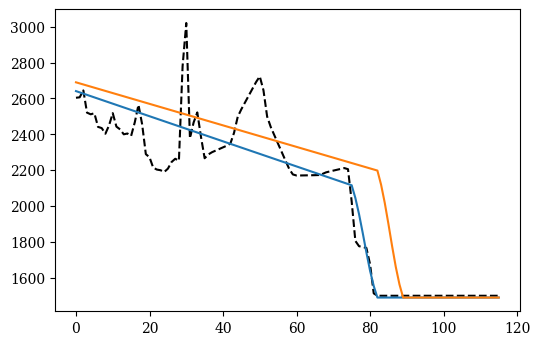

In [46]:
new_vp = np.zeros_like(model.vp)
vps=[]
for i in range(wb_taper.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i]) + 2
    fun = vmin * np.ones_like(new_vp[:, 0:1])
    fun[wb:, :] = 690 + fun[wb:, :] + 6 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
    vps.append(fun)
new_vp = np.concatenate(vps, -1)
new_vp = gaussian_filter(new_vp.copy(), **sigma_truncate)

print(new_vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(new_vp[-len(wlog):, log_idx])

Set new model as initial

In [47]:
vp = vp_cgg_tomo_long.copy()
# vp = new_vp.copy()
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

vp = np.where(wb_taper, np.min(vp_cgg), vp)
vs = np.where(wb_taper, 0, vs)
rho = np.where(wb_taper, 1000, rho)

# log = vplog.copy()
model = api.Model(vp, vs, rho, dx)

In [48]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -400.8610078720592	max: 484.6122728113698
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [49]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
DSCRC=5000;     dsrc=DSCRC
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

d.WRITE_STF = 0

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]

print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [21]:
d.NPROCX = 1
d.NPROCY = 1
par_forward = {'run_command': 'mpirun -np 30', 'disable': True}

In [50]:
d.forward(model, src, rec, **par_forward)

Current directory is /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
Init paths at ./out_for_pasha/
Init model:
	152 x 844, dx = 25.0 m
Check max source frequency:
	min Vs: 868.8613409770561 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.418551121702505 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 844 % 5 = 4


AssertionError: Error!!! Make sure NX % NPROCX = 0

In [23]:
# d.save_folder = root_fwi

In [30]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
print(d.DATA_DIR)
shots = d.get_shots(keys=['_p.'])
print(len(shots))
mpl.rcParams['figure.dpi']= 100
par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
        try:
            shot_s = shots[i]
            shot_f = data_p[i, :, ::d.NDT]
            vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
        except:
            print(f'Failed to fetch data for i={i}')
mpl.rcParams['figure.dpi']= 100

./out_for_pasha/su/seis
0


In [52]:
# wavefield_amp_ratio
print(np.max(np.abs(shot_f)) / np.max(np.abs(shot_s)) )

NameError: name 'shot_f' is not defined

# Compare syn and field

In [ ]:
wavelets_s = []
wavelets_f = []
print(data_p.shape)
print(len(shots))
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
    wavelets_f.append(data_p[i, :no, :nt:d.NDT].copy())
print(f'Total sources: {len(wavelets_f)}')
wavelets_s = np.concatenate(wavelets_s, 0)
wavelets_f = np.concatenate(wavelets_f, 0)

# !!! DO THIS IN FIELD DATA APPLICATION !!!
# THIS MAKES SYNTHETIC AND FIELD COMPARABLE
# OTHERWISE THERE IS INSANE AMPLITUDE MISMATCH
# wavelets_f /= np.max(wavelets_f)
# wavelets_f *= wavelets_s.max()

print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
print('Field wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_f.shape, wavelets_f.min(), wavelets_f.max()))

vis.plot_wiggles([wavelets_f, wavelets_s], n=10, colors=['r', 'b'], legend=['Field', 'Syn'])

In [ ]:
if shots:
    tvec = np.arange(nt) * d.DT
    plt.figure(figsize=(6,3)); 
    trace_idx = 0
    plt.plot(tvec, wavelets_f[trace_idx,:], 'r', lw=2, label='Field')
    plt.plot(tvec, wavelets_s[trace_idx,:], 'b', lw=2, label='Syn')
    # plt.plot(tvec, _dplotted[0][0], 'r', lw=2, label='Field')
    # plt.plot(tvec, _dplotted[1][0], 'b', lw=2, label='Syn')
    plt.legend()
    plt.xlabel('Time, sec')
    vis.savefig('wavelet_syn_field.png')

# REPLACE FIELD DATA BY MARM DATA

In [ ]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
# print(data_p.shape)

In [ ]:
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)

Geometric spreading correction (not used)

In [ ]:
geom = np.repeat(np.repeat(np.arange(1, data_p.shape[-1]+1)[np.newaxis, ...] * d.DT, data_p.shape[1], 0)[np.newaxis, ...], data_p.shape[0], 0) ** 0.5

# Overwrite by ones, so it is not used
geom = np.ones_like(geom)
data_p = data_p_backup * geom
# data_p = data_p_backup

In [ ]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape, data_p.min(), data_p.max())
dref = np.mean(data_p, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Save field data to a new folder in /su/

In [ ]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob.glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [ ]:
root_su_field = os.path.join(d._root_su, 'field/')
copy_su_from_to(d._root_su, root_su_field)

In [ ]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob.glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames
fnames = get_fnames_pattern(root_su_field + '*.su.*')

# Write field data into created .su files

In [ ]:
print(data_p.shape, geom.shape)
geom_slice = geom[0, ...]

In [ ]:
for i, f in enumerate(fnames):
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = data_p[i, :, ::d.NDT] / geom_slice[..., ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape, end='\r')

# Copy field data to folder with FWI for CNN and apply high-pass filter above 5 Hz

In [ ]:
from F_utils import *
from F_fwi import *
denise_root = '../'
results_path='./out_for_pasha/cnn'
d = api.Denise(denise_root, verbose=1)
d.save_folder=os.path.join(results_path,'fld','');      print(d.save_folder)
d.set_paths(makedirs=True)

In [ ]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
vis.plot_model(wb_taper)

In [ ]:
nx0 = 500
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
vis.plot_log_model(model.vp, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

### Abstraction over initial model

In [ ]:
model_init = copy.copy(model)
print(model_init)

In [ ]:
print(wlog.shape, vp.shape)
fig, ax = plt.subplots(1,1)
ax.plot(wlog)
ax.plot(vp[-len(wlog):, log_idx])

# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

In [ ]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
ax_depth = np.arange(len(wlog)) * dx / 1000
# ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, wlog[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log[::-1] / 1000, 'k--', label='Ideal initial')

# log_pred = model_init.vp[-len(wlog):, log_idx]

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:len(wlog)]))

In [ ]:
plot_logs(model_log, model_init, log_idx)

In [ ]:
ITERMAX=1

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

In [ ]:
d.INV_MOD_OUT=1
d.PHYSICS=1
d.SEISMO=2
d.QUELLTYPB=4
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30
# import loaders as ld
d.VPLOWERLIM = np.min(model_init.vp)
d.VSLOWERLIM = np.min(model_init.vs)
d.RHOLOWERLIM = np.min(model_init.rho)
# d.VPUPPERLIM = 3000.
# d.VSUPPERLIM = 2500.
# d.RHOUPPERLIM = 2500.
d.VPUPPERLIM =np.max(model_init.vp)+1000
d.VSUPPERLIM = np.max(model_init.vs)+500
d.RHOUPPERLIM = np.max(model_init.rho)+500
d.SWS_TAPER_FILE = 1
taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 8
taper[shift:, :] = wb_taper[:-shift,:] # water mask
plt.imshow(taper)
if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

# Run inversion to generate CNN data

In [ ]:
d.fwi_stages=[]
####################################### cnn_input_fwi_strategy  #########################################################
d.STEPMAX=200
################### gradient step length estimation
##########  testshots for gradient step length estimation,    (TESTSHOT_START,TESTSHOT_END,TESTSHOT_INCR) = 1,17,2
d.TESTSHOT_START=1; d.TESTSHOT_END=len(src._ones);  d.TESTSHOT_INCR=5
d.EPS_SCALE=0.0001
d.SCALEFAC=1.2
################### seismic data bandwidth
TIME_FILT=1
d.ITERMAX=ITERMAX
################### define fwi stages
########### make strong smoothing on low frequency data. [0,6] hz data
freq=8; wd_damp=0
d.add_fwi_stage(fc_low=0.0,fc_high=freq,time_filt=TIME_FILT,normalize=2,
    e_precond=0,spatfilter=0,pro=1e-2,
    wd_damp=wd_damp,wd_damp1=wd_damp)
freq=10; wd_damp=0
d.add_fwi_stage(fc_low=0.0,fc_high=freq,time_filt=TIME_FILT,normalize=2,
    e_precond=0,spatfilter=0,pro=1e-5,
    wd_damp=wd_damp,wd_damp1=wd_damp)
for i,stage in enumerate(d.fwi_stages):
    print(f'Stage {i+1}:\n\t{stage}\n')

d.DATA_DIR =os.path.join(d.save_folder,'su','seis')
# nodes number=10
print(model.vp.shape)
d.WRITE_STF = 0
d.NPROCX = 4
d.NPROCY = 1
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}
if d.DT is None:
    d.DT = 0.002
d.filename=os.path.join(d.save_folder,'seis_inversion.inp');    print(d.filename)
d.MFILE=os.path.join(d.save_folder,'start/model')
d.fwi(model_init, src, rec, **par_fwi_runtime)
d.MFILE=os.path.join(d.save_folder,'start/model_init')
d.fwi(model_init, src, rec, **par_fwi_runtime)

api._cmd('rm -r '+os.path.join(d.save_folder,'su'))
copy_su_from_to('./out_for_pasha/su/field',os.path.join(d.save_folder,'su'))
denise_folder_process('crop_zero_freqs',results_path,denise_root=denise_root)

In [ ]:
imports = 'import sys,os\n'
imports = imports+f"sys.path.append(os.getcwd())\n"
imports = imports+f"sys.path.append('/lustre/project/k1404/pavel/DENISE-Black-Edition')\n"
imports = imports+'from F_utils import *\n'
imports = imports+'from F_plotting import *\n'
imports = imports+'from F_fwi import *\n'
imports = imports+'import fnmatch\n'
imports = imports+'from glob import glob\n'
imports = imports+'import numpy as np\n'
imports = imports+'import pyapi_denise_pavel as api\n'
post_processing = imports
post_processing = post_processing+f"denise_folder_process('plot','{results_path}')\n"
# post_processing = post_processing+f"denise_folder_process('optimizing_space_','{results_path}')\n"
# post_processing = post_processing+f"denise_folder_process('plot','{results_path}')\n"
post_processing_script_name = os.path.join(d.save_folder,'post_processing_script.py')
print(post_processing_script_name)
f = open(post_processing_script_name,'w');  f.write(post_processing);   f.close()
create_sbatch_file_for_fwi_folder('cnn.sh',results_path)
print('scp -r plotnips@10.68.138.162:/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/out_for_pasha/cnn /lustre/project/k1404/pavel/DENISE-Black-Edition/for_pasha/out_for_pasha')

# Run inversion on full-frequency range with proofed to work strategy

In [ ]:
import F_fwi
# %%capture
results_path='./out_for_pasha/fwi_full_spectrum'
d = api.Denise(denise_root, verbose=0)
d.save_folder=os.path.join(results_path,'fld','');      print(d.save_folder)
d.set_paths(makedirs=True)
d.INV_MOD_OUT=1
d.PHYSICS=1
d.SEISMO=2
d.QUELLTYPB=4
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30
d.ITERMAX=ITERMAX
# import loaders as ld
d.VPLOWERLIM = np.min(model_init.vp)
d.VSLOWERLIM = np.min(model_init.vs)
d.RHOLOWERLIM = np.min(model_init.rho)
# d.VPUPPERLIM = 3000.
# d.VSUPPERLIM = 2500.
# d.RHOUPPERLIM = 2500.
d.VPUPPERLIM =np.max(model_init.vp)+1000
d.VSUPPERLIM = np.max(model_init.vs)+500
d.RHOUPPERLIM = np.max(model_init.rho)+500
d.SWS_TAPER_FILE = 1
taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 8
taper[shift:, :] = wb_taper[:-shift,:] # water mask
plt.imshow(wb_taper-taper)

if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
###################################### full_fwi_strategy  #########################################################
par_stages_fwi={'inv_vs_iter': 0,
                 'inv_rho_iter': 0,
                 'normalize': 2,
                 'order': 6,
                }
d.fwi_stages = []
freqs_high = [3, 4, 5, 6, 7]
grad_smoothing = [2, 1.5, 0.5, 0.25, 0.125]
lnorms = [2, 2, 2, 2, 2, 2]
spatfilters = [4, 4, 0, 0, 0, 0]
for i, freq in enumerate(freqs_high):
    d.add_fwi_stage(fc_high=freq, 
                    wd_damp=grad_smoothing[i],
                    wd_damp1=grad_smoothing[i],
                    lnorm=lnorms[i],
                    spatfilter=spatfilters[i],
                    **par_stages_fwi)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')
d.DATA_DIR =os.path.join(d.save_folder,'su','seis')
d.WRITE_STF = 0
# d.NPROCX = 4;   d.NPROCY = 1
d.NPROCX = 8;   d.NPROCY = 2
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}
if d.DT is None:
    d.DT = 0.002
d.filename=os.path.join(d.save_folder,'seis_inversion.inp');    print(d.filename)
d.MFILE=os.path.join(d.save_folder,'start/model')
d.fwi(model_init, src, rec, **par_fwi_runtime)
copy_su_from_to('./out_for_pasha/su/field',os.path.join(d.save_folder,'su'))
# denise_folder_process('crop_zero_freqs',results_path,denise_root=denise_root)
d.MFILE=os.path.join(d.save_folder,'start/model_init')
d.fwi(model_init, src, rec, **par_fwi_runtime)

# copy_su_from_to('./out_for_pasha/su/field',os.path.join(d.save_folder,'su'))
post_processing_script_name = os.path.join(d.save_folder,'post_processing_script.py')
print(post_processing_script_name)
post_processing = imports
post_processing = post_processing+f"denise_folder_process('plot','{results_path}')\n"
# post_processing = post_processing+f"denise_folder_process('optimizing_space_','{results_path}')\n"
# post_processing = post_processing+f"denise_folder_process('plot','{results_path}')\n"
f = open(post_processing_script_name, 'w')
f.write(post_processing)
f.close()
create_sbatch_file_for_fwi_folder('fwi_full_spectrum.sh',results_path)

In [ ]:
print(results_path)

### Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

In [ ]:
# d.set_model(model_init)
# print(d.save_folder)
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=wlog, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [ ]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

### Gradients

In [ ]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

In [ ]:
def get_model_last():
    all_fnames = []
    # vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    vps, fnames = d.get_fwi_models(['vp'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho'], return_filenames=True)
    all_fnames += fnames
    print(all_fnames)
    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)
    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    # print(vps)
    return model_last
    # return None
model_last=get_model_last()

In [ ]:
vis.plot_model(model_last.vp / 1000, **limits_vp)

# Compare wavefiedls before/after

In [ ]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)
print(d.save_folder)
if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

In [ ]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [ ]:
print(par_forward)

In [ ]:
d.NPROCX = 1
d.NPROCY = 1
d.forward(model_last, src, rec, **par_forward)

In [ ]:
print(src.x[19], src.x[62])

In [ ]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

mpl.rcParams['figure.dpi']= 300
# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 5)]:
for ishot in [19, 62]:
    print(ishot)
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.0125, colorbar=False, dt=d.DT, dx=dx)
mpl.rcParams['figure.dpi']= 100